## This code containts forecasts using time series methods (ES and AR) and ML methods (tree ensembles using GB and XGB) for Calls Data

In [2]:
# Commonly used python functions and display settings
import pandas as pd
import numpy as np
pd.options.display.float_format = '{:,.2f}'.format

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.core.display import display, HTML

import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages

C:\Windows\Temp\ipykernel_4232\597316197.py:8: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [3]:
# Key imports for this code (various ML and Stat Models)
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
import pmdarima as pm
from pmdarima import model_selection
from pmdarima import auto_arima

In [4]:
# import viz libraries
import matplotlib.pyplot as plt
import plotly
plotly.offline.init_notebook_mode(connected=True)
from plotly.graph_objs import *
from plotly import tools
import plotly.graph_objects as go
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot

### Preliminary Data Analysis

In [5]:
# fetch data from the CSV file
calls_df = pd.read_csv('calls_data.csv', parse_dates = ['date'])

calls_df.head()
calls_df.tail()

,date,calls
0,1979-01-31,116.63
1,1979-02-28,100.80
2,1979-03-31,106.82
3,1979-04-30,103.49
4,1979-05-31,91.76


,date,calls
475,2018-08-31,222.64
476,2018-09-30,186.75
477,2018-10-31,201.84
478,2018-11-30,182.68
479,2018-12-31,243.19


In [6]:
# Creating a plot of calls made over time
plot_data = []
plot_data.append(go.Scatter(x= calls_df['date'], y= calls_df['calls']))
layout = go.Layout(xaxis = dict(title='Date'), yaxis = dict(title= 'Calls Made'), 
                   title = 'Time Series of Monthly Calls Made')
fig = go.Figure(data= plot_data, layout=layout)

plotly.offline.iplot(fig)

In [7]:
# Zooming into the 100th to 119th data points of above plot
plot_data = []
plot_data.append(go.Scatter(x= calls_df['date'][100:120], y= calls_df['calls'][100:120]))
layout = go.Layout(xaxis = dict(title='Date'), yaxis = dict(title= 'Calls Made'), 
                   title = 'Time Series of Monthly Calls Made')
fig = go.Figure(data= plot_data, layout=layout)

plotly.offline.iplot(fig)

In [8]:
# Representing above plot using dots
plot_data = []
plot_data.append(go.Scatter(x= calls_df['date'][100:120], y= calls_df['calls'][100:120], mode = 'markers'))
layout = go.Layout(xaxis = dict(title='Date'), yaxis = dict(title= 'Calls Made'), 
                   title = 'Time Series of Monthly Calls Made')
fig = go.Figure(data= plot_data, layout=layout)

plotly.offline.iplot(fig)

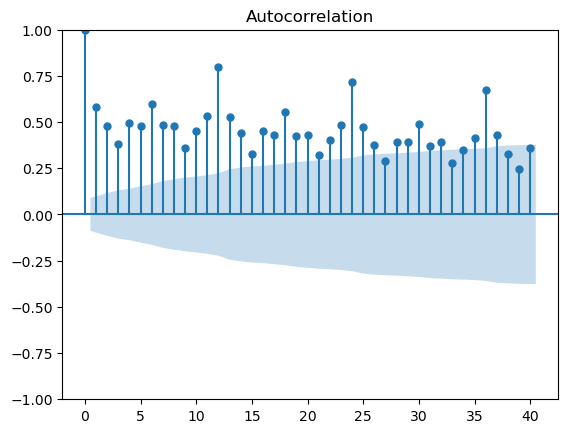

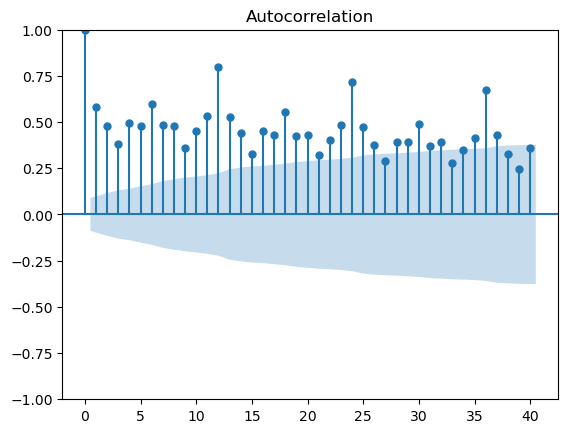

In [9]:
# This creates a graph of the autocorrelation function versus lags for the calls data
sm.graphics.tsa.plot_acf(calls_df['calls'].values.squeeze(), lags=40)

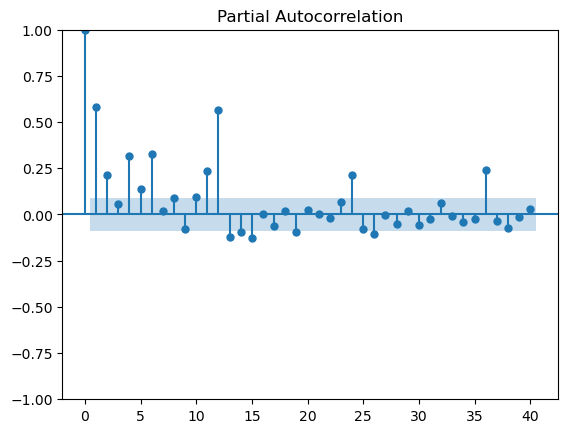

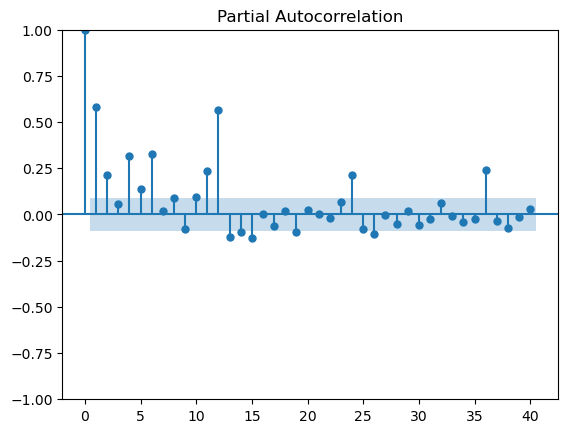

In [10]:
# This creates a graph of the partial autocorrelation function versus lags for the calls data
sm.graphics.tsa.plot_pacf(calls_df['calls'].values.squeeze(), lags=40)

In [11]:
# subset data to only include 300 data points (most recent)
# ES and ARIMA methods are better with < 200 training data points

subset_data = calls_df[calls_df['date'] > '1994-01-01'].reset_index(drop = True)
len(subset_data)
subset_data.head()
subset_data.isna().sum()

300

,date,calls
0,1994-01-31,160.05
1,1994-02-28,163.15
2,1994-03-31,173.05
3,1994-04-30,158.49
4,1994-05-31,162.24


date     0
calls    0
dtype: int64

## Exponential Smoothing

In [12]:
# First we get the time series
time_series = subset_data['calls']

# Define the seasonal periods
seasonal_periods = 12 

# Define the number of predictions to make 
h = 1

# Define the length of each training set
T = 200

# Initialize the lists to store the percentage and absolute errors
perc_error_list = []
abs_error_list = []

es_preds_train = np.zeros(T+h) # In case we wish to use the ES predictions

# Loop through the data frame and make predictions using exponential smoothing
for i in range(len(time_series) - T - h):
    # Define the training and testing data sets
    train = time_series.iloc[i:i+T].values
    test = time_series.iloc[i+T:i+T+h].values
    
    # Fit the exponential smoothing model
    model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=seasonal_periods)
    fit_model = model.fit()
    
    # Make predictions
    pred_list = fit_model.forecast(h)
    preds = pred_list[h-1]

    # Calculate percentage and absolute errors
    perc_errors = np.abs(test[h-1]-preds)/test[h-1]
    abs_errors = np.abs(test[h-1]-preds)

    # Store the percentage and absolute errors
    perc_error_list.append(perc_errors)
    abs_error_list.append(abs_errors)
    
    # Get the ES predictions
    es_preds_train = np.append(es_preds_train, preds) 

In [13]:
# Print the percentage-error results
print('Mean absolute percentage error:', np.mean(perc_error_list, axis = 0))
print('Median absolute percentage error:', np.median(perc_error_list, axis = 0))
print('75th percentile of absolute percentage error:', np.percentile(perc_error_list, 75, axis = 0))
print('90th percentile of absolute percentage error:', np.percentile(perc_error_list, 90, axis = 0))

Mean absolute percentage error: 0.056791053969736466
Median absolute percentage error: 0.04838503926440052
75th percentile of absolute percentage error: 0.08385384571849411
90th percentile of absolute percentage error: 0.10957943163493758


In [14]:
# Print the absolute error ratio results
avg_global = subset_data['calls'][T+h:].mean()
print('Mean absolute error ratio:', np.mean(abs_error_list, axis = 0)/avg_global)
print('Median absolute error ratio:', np.median(abs_error_list, axis = 0)/avg_global)
print('75th percentile absolute error ratio:', np.percentile(abs_error_list, 75, axis = 0)/avg_global)
print('90th percentile absolute error ratio:', np.percentile(abs_error_list, 90, axis = 0)/avg_global)

Mean absolute error ratio: 0.05493645608329439
Median absolute error ratio: 0.05079227292708605
75th percentile absolute error ratio: 0.08189088619217312
90th percentile absolute error ratio: 0.11630379236277354


## SARIMAX initial model building and then train & predict

In [15]:
# Getting optimal differencing 
d_opt = pm.arima.ndiffs(subset_data['calls'].iloc[0:T])
d_opt
D_opt = pm.arima.nsdiffs(subset_data['calls'].iloc[0:T], m = seasonal_periods)
D_opt

1

0

,date,calls,diff1,diff2
0,1994-01-31,160.05,NaN,NaN
1,1994-02-28,163.15,3.10,NaN
2,1994-03-31,173.05,9.89,6.80
3,1994-04-30,158.49,-14.56,-24.46
4,1994-05-31,162.24,3.76,18.32


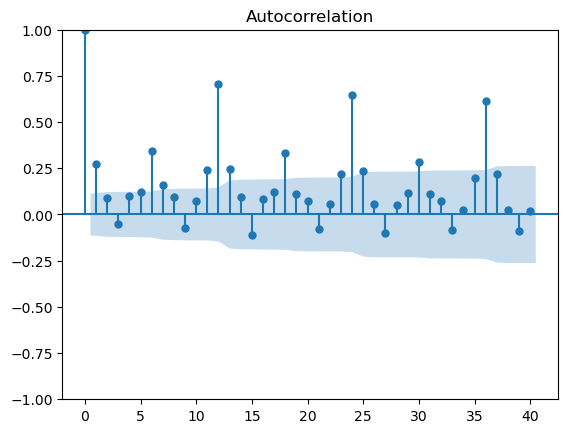

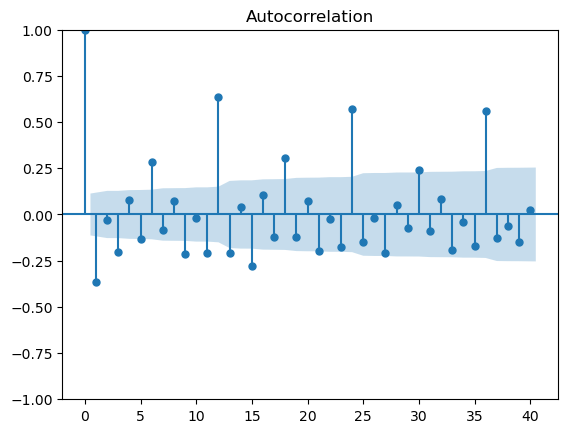

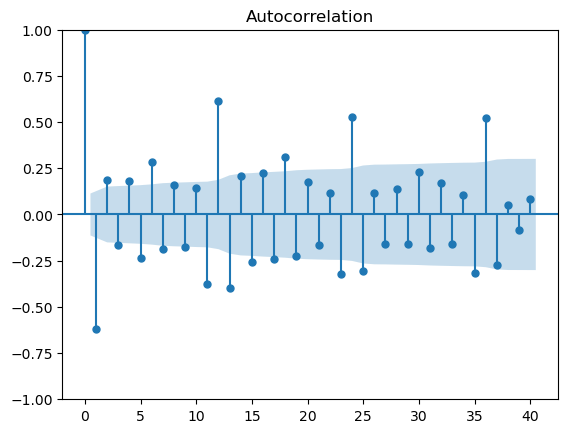

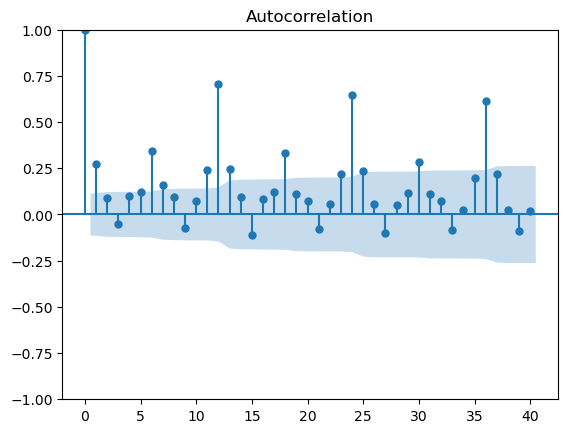

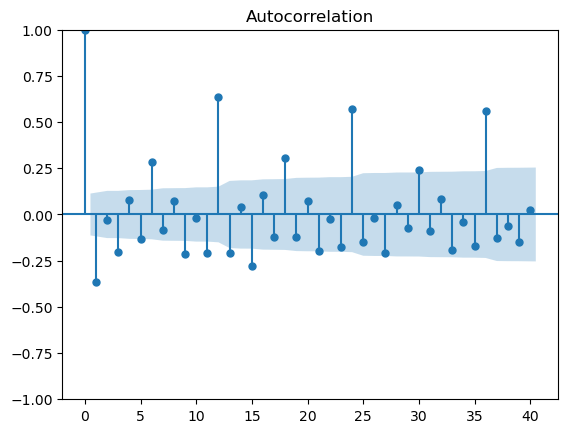

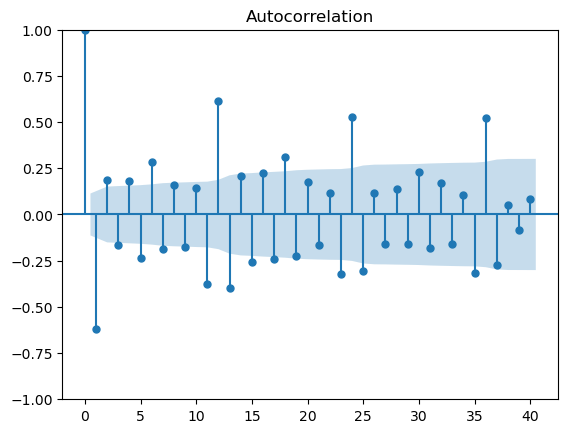

In [16]:
# Graphical study of the effect of differencing
subset_data['diff1'] = subset_data['calls'] - subset_data['calls'].shift(periods = 1)
subset_data['diff2'] = subset_data['diff1'] - subset_data['diff1'].shift(periods = 1)
subset_data.head()

sm.graphics.tsa.plot_acf(subset_data['calls'].values.squeeze(), lags=40)
sm.graphics.tsa.plot_acf(subset_data['diff1'].dropna().values.squeeze(), lags=40)
sm.graphics.tsa.plot_acf(subset_data['diff2'].dropna().values.squeeze(), lags=40)

In [17]:
# That we just to show, now we need to remove the columns we created in the previous cell
subset_data.drop(columns = ['diff1', 'diff2'], inplace = True)
subset_data.head()

,date,calls
0,1994-01-31,160.05
1,1994-02-28,163.15
2,1994-03-31,173.05
3,1994-04-30,158.49
4,1994-05-31,162.24


In [18]:
# Initialize the lists to store the percentage and absolute errors
ar_perc_error_list = []
ar_abs_error_list = []

ar_preds_train = np.zeros(T+h) # In case we wish to use the ARIMA predictions

# Loop through the data frame and make predictions using ARIMA
for i in range(len(time_series) - T - h):
    # Define the training and testing data sets
    train = time_series.iloc[i:i+T].values
    test = time_series.iloc[i+T:i+T+h].values

    # Using a specified order (this would need to be fine-tuned)
    order = (1, 1, 0) 
    seasonal_order = (1, 0, 0, seasonal_periods) 

    # Fit the SARIMAX or ARIMA model
    model = SARIMAX(endog=train, exog=None, order=order, seasonal_order=seasonal_order)
    fit_model = model.fit(disp=False)

    # Make predictions
    pred_list = fit_model.forecast(steps=len(test), exog=None)
    preds = pred_list[h-1]

    # Calculate percentage and absolute errors
    ar_perc_errors = np.abs(test[h-1]-preds)/test[h-1]
    ar_abs_errors = np.abs(test[h-1]-preds)

    # Store the percentage and absolute errors
    ar_perc_error_list.append(ar_perc_errors)
    ar_abs_error_list.append(ar_abs_errors)
    
    # Get the ARIMA predictions
    ar_preds_train = np.append(ar_preds_train, preds) 

In [19]:
# Print the percentage-error results
print('Mean absolute percentage error:', np.mean(ar_perc_error_list, axis = 0))
print('Median absolute percentage error:', np.median(ar_perc_error_list, axis = 0))
print('75th percentile of absolute percentage error:', np.percentile(ar_perc_error_list, 75, axis = 0))
print('90th percentile of absolute percentage error:', np.percentile(ar_perc_error_list, 90, axis = 0))

Mean absolute percentage error: 0.08358052507742121
Median absolute percentage error: 0.07581434156163701
75th percentile of absolute percentage error: 0.12954856633073292
90th percentile of absolute percentage error: 0.15938018732514536


In [20]:
# Print the absolute error ratio results
print('Mean absolute error ratio:', np.mean(ar_abs_error_list, axis = 0)/avg_global)
print('Median absolute error ratio:', np.median(ar_abs_error_list, axis = 0)/avg_global)
print('75th percentile absolute error ratio:', np.percentile(ar_abs_error_list, 75, axis = 0)/avg_global)
print('90th percentile absolute error ratio:', np.percentile(ar_abs_error_list, 90, axis = 0)/avg_global)

Mean absolute error ratio: 0.08212696993058166
Median absolute error ratio: 0.07483856589113994
75th percentile absolute error ratio: 0.12624973774376286
90th percentile absolute error ratio: 0.16153553181892466


### For Gradient Boosting we first do some trend adjustment

In [21]:
# For the ML Models we use the dates to obtain the month and year as features
subset_data['month'] = subset_data['date'].dt.month
subset_data['year'] = subset_data['date'].dt.year
subset_data.head()
subset_data.tail()

,date,calls,month,year
0,1994-01-31,160.05,1,1994
1,1994-02-28,163.15,2,1994
2,1994-03-31,173.05,3,1994
3,1994-04-30,158.49,4,1994
4,1994-05-31,162.24,5,1994


,date,calls,month,year
295,2018-08-31,222.64,8,2018
296,2018-09-30,186.75,9,2018
297,2018-10-31,201.84,10,2018
298,2018-11-30,182.68,11,2018
299,2018-12-31,243.19,12,2018


In [22]:
# To get the trend, we average across all months of a year (using only training data)
yearly_avg = subset_data[['calls', 'year']].iloc[0:T].groupby(['year']).mean()
yearly_avg

,calls
year,
1994,177.71
1995,172.41
1996,172.13
1997,171.18
1998,182.82
1999,175.21
2000,186.32
2001,182.51
2002,182.89


In [23]:
# We can bring the year back as a feature (above it is in the index, so we reset it)
yearly_avg.reset_index(inplace = True)

In [24]:
# Regression model to fit a linear trend model

model = LinearRegression(fit_intercept = True)
model.fit(yearly_avg['year'].array.reshape(-1, 1), yearly_avg['calls']) # When extending to multiple features remove .array.reshape(-1, 1)

# The following gives the R-square score
model.score(yearly_avg['year'].array.reshape(-1, 1), yearly_avg['calls'])

# This is the coefficient Beta_1 (or slope of the Simple Linear Regression line)
model.coef_

# This is the coefficient Beta_0
model.intercept_

LinearRegression()

0.8160847607532771

array([1.49954221])

-2817.954686373141

In [25]:
# Applying the trend for the test and train dataset across all months
subset_data['trend'] = -2817.955 + 1.4995*(subset_data['year']+subset_data['month']/12)
subset_data.head()

,date,calls,month,year,trend
0,1994-01-31,160.05,1,1994,172.17
1,1994-02-28,163.15,2,1994,172.30
2,1994-03-31,173.05,3,1994,172.42
3,1994-04-30,158.49,4,1994,172.55
4,1994-05-31,162.24,5,1994,172.67


In [26]:
# Plotting the trend line (regression line) along with the monthly calls data
plot_data = []
plot_data.append(go.Scatter(x= subset_data['date'], y= subset_data['calls'], name = 'calls'))
plot_data.append(go.Scatter(x= subset_data['date'], y= subset_data['trend'], name = 'trend'))
layout = go.Layout(xaxis = dict(title='Date'), yaxis = dict(title= 'Calls Made and Trend'), 
                   title = 'Time Series of Monthly Calls Made with Trend')
fig = go.Figure(data= plot_data, layout=layout)

plotly.offline.iplot(fig)

In [27]:
# To get some of the lag features later we would need the full data set, and extract the date and year; trend
calls_df['month'] = calls_df['date'].dt.month
calls_df['year'] = calls_df['date'].dt.year
calls_df['trend'] = -2817.955 + 1.4995*(calls_df['year']+calls_df['month']/12)

In [28]:
# Residuals (de-trending) and shifting them to get lags by 1 month and 12 months
subset_data['resid_lags'] = (calls_df['calls']-calls_df['trend']).shift(periods = 
                                                seasonal_periods)[-len(subset_data):].reset_index(drop = True)
subset_data['resid_lag1'] = (calls_df['calls']-calls_df['trend']).shift(periods = 
                                                        1)[-len(subset_data):].reset_index(drop = True)
subset_data.head(15)
subset_data.tail()

,date,calls,month,year,trend,resid_lags,resid_lag1
0,1994-01-31,160.05,1,1994,172.17,-9.96,7.11
1,1994-02-28,163.15,2,1994,172.30,-34.48,-12.12
2,1994-03-31,173.05,3,1994,172.42,-8.11,-9.14
3,1994-04-30,158.49,4,1994,172.55,-28.58,0.63
4,1994-05-31,162.24,5,1994,172.67,-18.62,-14.06
5,1994-06-30,203.78,6,1994,172.80,33.04,-10.43
6,1994-07-31,210.04,7,1994,172.92,22.47,30.98
7,1994-08-31,188.81,8,1994,173.05,42.73,37.11
8,1994-09-30,161.82,9,1994,173.17,-20.27,15.76
9,1994-10-31,178.58,10,1994,173.30,-5.12,-11.35


,date,calls,month,year,trend,resid_lags,resid_lag1
295,2018-08-31,222.64,8,2018,209.04,17.64,25.41
296,2018-09-30,186.75,9,2018,209.16,7.93,13.60
297,2018-10-31,201.84,10,2018,209.29,-8.42,-22.41
298,2018-11-30,182.68,11,2018,209.41,-16.32,-7.44
299,2018-12-31,243.19,12,2018,209.54,18.07,-26.73


In [29]:
# Obtaining the training data (note: unlike ES and ARIMA, here we do not retrain)
X_train = subset_data[0:T]
X_train['residual'] = X_train['calls'] - X_train['trend']
X_train.head()
X_train.tail()
# The "y" variable that we predict is the residual itself
y_train = X_train['residual']
y_train

,date,calls,month,year,trend,resid_lags,resid_lag1,residual
0,1994-01-31,160.05,1,1994,172.17,-9.96,7.11,-12.12
1,1994-02-28,163.15,2,1994,172.30,-34.48,-12.12,-9.14
2,1994-03-31,173.05,3,1994,172.42,-8.11,-9.14,0.63
3,1994-04-30,158.49,4,1994,172.55,-28.58,0.63,-14.06
4,1994-05-31,162.24,5,1994,172.67,-18.62,-14.06,-10.43


,date,calls,month,year,trend,resid_lags,resid_lag1,residual
195,2010-04-30,172.89,4,2010,196.54,-16.91,-7.49,-23.65
196,2010-05-31,188.69,5,2010,196.66,-4.54,-23.65,-7.97
197,2010-06-30,213.24,6,2010,196.79,24.75,-7.97,16.45
198,2010-07-31,221.73,7,2010,196.91,37.84,16.45,24.81
199,2010-08-31,217.57,8,2010,197.04,17.43,24.81,20.53


0     -12.12
1      -9.14
2       0.63
3     -14.06
4     -10.43
       ...  
195   -23.65
196    -7.97
197    16.45
198    24.81
199    20.53
Name: residual, Length: 200, dtype: float64

In [30]:
# The remaining 100 data points are test data
X_test = subset_data[T:]
X_test.head()
X_test.tail()

,date,calls,month,year,trend,resid_lags,resid_lag1
200,2010-09-30,192.99,9,2010,197.16,-21.12,20.53
201,2010-10-31,168.57,10,2010,197.29,-11.96,-4.18
202,2010-11-30,180.52,11,2010,197.41,13.19,-28.72
203,2010-12-31,227.85,12,2010,197.54,28.36,-16.90
204,2011-01-31,167.04,1,2011,197.66,-8.77,30.31


,date,calls,month,year,trend,resid_lags,resid_lag1
295,2018-08-31,222.64,8,2018,209.04,17.64,25.41
296,2018-09-30,186.75,9,2018,209.16,7.93,13.60
297,2018-10-31,201.84,10,2018,209.29,-8.42,-22.41
298,2018-11-30,182.68,11,2018,209.41,-16.32,-7.44
299,2018-12-31,243.19,12,2018,209.54,18.07,-26.73


## GB (Gradient Boosting)

In [31]:
# Just so we have the test and training data for the GB to choose the right features in the next cell
X_train
X_test

,date,calls,month,year,trend,resid_lags,resid_lag1,residual
0,1994-01-31,160.05,1,1994,172.17,-9.96,7.11,-12.12
1,1994-02-28,163.15,2,1994,172.30,-34.48,-12.12,-9.14
2,1994-03-31,173.05,3,1994,172.42,-8.11,-9.14,0.63
3,1994-04-30,158.49,4,1994,172.55,-28.58,0.63,-14.06
4,1994-05-31,162.24,5,1994,172.67,-18.62,-14.06,-10.43
...,...,...,...,...,...,...,...,...
195,2010-04-30,172.89,4,2010,196.54,-16.91,-7.49,-23.65
196,2010-05-31,188.69,5,2010,196.66,-4.54,-23.65,-7.97
197,2010-06-30,213.24,6,2010,196.79,24.75,-7.97,16.45
198,2010-07-31,221.73,7,2010,196.91,37.84,16.45,24.81


,date,calls,month,year,trend,resid_lags,resid_lag1
200,2010-09-30,192.99,9,2010,197.16,-21.12,20.53
201,2010-10-31,168.57,10,2010,197.29,-11.96,-4.18
202,2010-11-30,180.52,11,2010,197.41,13.19,-28.72
203,2010-12-31,227.85,12,2010,197.54,28.36,-16.90
204,2011-01-31,167.04,1,2011,197.66,-8.77,30.31
...,...,...,...,...,...,...,...
295,2018-08-31,222.64,8,2018,209.04,17.64,25.41
296,2018-09-30,186.75,9,2018,209.16,7.93,13.60
297,2018-10-31,201.84,10,2018,209.29,-8.42,-22.41
298,2018-11-30,182.68,11,2018,209.41,-16.32,-7.44


In [32]:
# One shot training (i.e., no re-training)

# defining the model and parameters
gb = GradientBoostingRegressor(n_estimators = 50, max_depth = 5, min_samples_leaf = 3)

# Asking the model to fit the training data (features used: month, resid_lags, resid_lag1)
gb = gb.fit(X_train.drop(columns = ['date', 'calls', 'year', 'trend', 'residual']), y_train) 

# Asking what the importance of features
gb.feature_importances_

array([0.11498612, 0.78874376, 0.09627012])

In [33]:
# Testing for one shot training
# Initialize the lists to store the percentage and absolute errors
gb_perc_error_list = []
gb_abs_error_list = []

# Make predictions using Gradient Boosting with a single run of train

y_test = X_test['calls'] # This is the final prediction that we will compare against

# Make predictions (residuals plus trend)
y_preds = gb.predict(X_test.drop(columns = ['date', 'calls', 'year', 'trend'])) + X_test['trend']

# Calculate percentage and absolute errors
perc_errors = np.abs(y_test-y_preds)/y_test
abs_errors = np.abs(y_test-y_preds)

# Store the percentage and absolute errors
gb_perc_error_list.append(perc_errors)
gb_abs_error_list.append(abs_errors)

In [34]:
# Print the percentage-error results
print('Mean absolute percentage error:', np.mean(gb_perc_error_list))
print('Median absolute percentage error:', np.median(gb_perc_error_list))
print('75th percentile of absolute percentage error:', np.percentile(gb_perc_error_list, 75))
print('90th percentile of absolute percentage error:', np.percentile(gb_perc_error_list, 90))

Mean absolute percentage error: 0.06565376528683504
Median absolute percentage error: 0.05594851106319261
75th percentile of absolute percentage error: 0.08828315422954743
90th percentile of absolute percentage error: 0.13539924158823863


In [35]:
# Print the absolute error ratio results
print('Mean absolute error ratio:', np.mean(gb_abs_error_list)/avg_global)
print('Median absolute error ratio:', np.median(gb_abs_error_list)/avg_global)
print('75th percentile absolute error ratio:', np.percentile(gb_abs_error_list, 75)/avg_global)
print('90th percentile absolute error ratio:', np.percentile(gb_abs_error_list, 90)/avg_global)

Mean absolute error ratio: 0.062492821093121355
Median absolute error ratio: 0.057408663448752846
75th percentile absolute error ratio: 0.09206281085063385
90th percentile absolute error ratio: 0.13549304799976233


In [36]:
# Comparing the forecasts against the actuals, graphically
plot_data = []
plot_data.append(go.Scatter(x= subset_data['date'][T+1:], y= subset_data['calls'][T+1:], name = 'calls'))
plot_data.append(go.Scatter(x= subset_data['date'][T+1:], y= y_preds[1:], name = 'GB', mode = 'markers'))
plot_data.append(go.Scatter(x= subset_data['date'][T+1:], y= es_preds_train[T+1:], name = 'ES', mode = 'markers'))
plot_data.append(go.Scatter(x= subset_data['date'][T+1:], y= ar_preds_train[T+1:], name = 'AR', mode = 'markers'))
layout = go.Layout(xaxis = dict(title='Date'), yaxis = dict(title= 'Calls made versus predicted'), 
                   title = 'Monthly Calls Test Data vs. Predictions')
fig = go.Figure(data= plot_data, layout=layout)

plotly.offline.iplot(fig)

In [37]:
# Model forecasts versus actuals across 2 years
plot_data = []
plot_data.append(go.Scatter(x= subset_data['date'][T+1:T+25], y= subset_data['calls'][T+1:T+25], name = 'calls'))
plot_data.append(go.Scatter(x= subset_data['date'][T+1:T+25], y= y_preds[1:T+25], name = 'GB', mode = 'markers'))
plot_data.append(go.Scatter(x= subset_data['date'][T+1:T+25], y= es_preds_train[T+1:T+25], name = 'ES', mode = 'markers'))
plot_data.append(go.Scatter(x= subset_data['date'][T+1:T+25], y= ar_preds_train[T+1:T+25], name = 'AR', mode = 'markers'))
layout = go.Layout(xaxis = dict(title='Date'), yaxis = dict(title= 'Calls made versus predicted'), 
                   title = 'Monthly Calls Test Data vs. Predictions')
fig = go.Figure(data= plot_data, layout=layout)

plotly.offline.iplot(fig)

## XGBoost

In [ ]:
# If we simply use the parameters without hyper parameter tuning
# One shot training

# Define the XGBoost regressor with specific hyperparameters
model = XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=1.0,
    colsample_bytree=1.0,
    objective='reg:squarederror',
    random_state=42
)

# Asking the model to fit the training data
model.fit(X_train.drop(columns = ['date', 'calls', 'year', 'trend', 'residual']), y_train) 

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [39]:
# One shot training
# Initialize the lists to store the percentage and absolute errors
xgb_perc_error_list = []
xgb_abs_error_list = []

# Make predictions using Xtreme Gradient Boosting with a single run of train

y_test = X_test['calls']

# Make predictions
y_preds = model.predict(X_test.drop(columns = ['date', 'calls', 'year', 'trend'])) + X_test['trend']

# Calculate percentage and absolute errors
perc_errors = np.abs(y_test-y_preds)/y_test
abs_errors = np.abs(y_test-y_preds)

# Store the percentage and absolute errors
xgb_perc_error_list.append(perc_errors)
xgb_abs_error_list.append(abs_errors)

In [40]:
# Print the percentage-error results
print('Mean absolute percentage error:', np.mean(xgb_perc_error_list, axis = 1))
print('Median absolute percentage error:', np.median(xgb_perc_error_list, axis = 1))
print('75th percentile of absolute percentage error:', np.percentile(xgb_perc_error_list, 75, axis = 1))
print('90th percentile of absolute percentage error:', np.percentile(xgb_perc_error_list, 90, axis = 1))

Mean absolute percentage error: [0.06465959]
Median absolute percentage error: [0.05525418]
75th percentile of absolute percentage error: [0.08962071]
90th percentile of absolute percentage error: [0.13615874]


In [41]:
# Print the absolute error ratio results
print('Mean absolute error ratio:', np.mean(xgb_abs_error_list, axis = 1)/avg_global)
print('Median absolute error ratio:', np.median(xgb_abs_error_list, axis = 1)/avg_global)
print('75th percentile absolute error ratio:', np.percentile(xgb_abs_error_list, 75, axis = 1)/avg_global)
print('90th percentile absolute error ratio:', np.percentile(xgb_abs_error_list, 90, axis = 1)/avg_global)

Mean absolute error ratio: [0.06152881]
Median absolute error ratio: [0.05124117]
75th percentile absolute error ratio: [0.08775255]
90th percentile absolute error ratio: [0.1307467]
